In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

import tushare as ts
token = 'YOUR_TOKEN'
pro = ts.pro_api(token)

def get_cal_date(star, end):
    cal_date = pro.trade_cal(exchange='', start_date=start, end_date=end)
    cal_date = cal_date[cal_date.is_open==1]
    dates = cal_date.cal_date.values
    return dates

def get_north_money(start, end):
    dates = get_cal_date(start, end)
    df = pro.moneyflow_hsgt(start_date=start, end_date=end)
    for i in range(0, len(dates)-300, 300):
        d0 = pro.moneyflow_hsgt(start_date = dates[i], end_date = dates[i+300])
        df = pd.concat([d0,df])
        df = df.drop_duplicates()
        df.index = pd.to_datetime(df.trade_date)
        df = df.sort_index()
    return df

def get_index_data(code, start, end):
    index_df = pro.index_daily(ts_code = code, start_date = start, end_date = end)
#     print(index_df)
    index_df.index = pd.to_datetime(index_df.trade_date)
    index_df = index_df.sort_index()
    return index_df

In [78]:
indexs = {'沪深300': '000300.SH', '中证500': '000905.SH'}
start = '20141117'
end = '20200815'
index_data = pd.DataFrame()
for name, code in indexs.items():
    index_data[name] = get_index_data(code, start, end)['close']

In [79]:
print(index_data['沪深300'])

trade_date
2014-11-17    2567.1010
2014-11-18    2541.4160
2014-11-19    2537.2230
2014-11-20    2537.0990
2014-11-21    2583.4550
                ...    
2020-08-10    4724.8697
2020-08-11    4681.7837
2020-08-12    4647.6446
2020-08-13    4635.7126
2020-08-14    4704.6288
Name: 沪深300, Length: 1402, dtype: float64


In [80]:
print(index_data.iloc[0])

沪深300     2567.1
中证500    4958.47
兴全300        NaN
Name: 2014-11-17 00:00:00, dtype: object


In [81]:
print(index_data/index_data.iloc[0])

               沪深300     中证500 兴全300
trade_date                          
2014-11-17  1.000000  1.000000   NaN
2014-11-18  0.989995  1.001852   NaN
2014-11-19  0.988361  1.005372   NaN
2014-11-20  0.988313  1.003259   NaN
2014-11-21  1.006371  1.014381   NaN
...              ...       ...   ...
2020-08-10  1.840547  1.356326   NaN
2020-08-11  1.823763  1.331228   NaN
2020-08-12  1.810464  1.316617   NaN
2020-08-13  1.805816  1.321509   NaN
2020-08-14  1.832662  1.335809   NaN

[1402 rows x 3 columns]


<function matplotlib.pyplot.show(*args, **kw)>

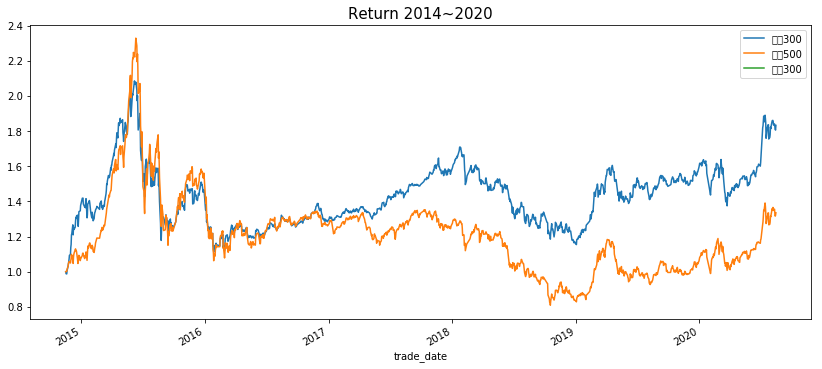

In [82]:
(index_data/index_data.iloc[0]).plot(figsize=(14,6))
plt.title('Return 2014~2020', size=15)
plt.show

In [83]:
all_ret = index_data/index_data.shift(1) - 1
north_data = get_north_money(start, end)
print(all_ret)
print(north_data)

               沪深300     中证500 兴全300
trade_date                          
2014-11-17       NaN       NaN   NaN
2014-11-18 -0.010005  0.001852   NaN
2014-11-19 -0.001650  0.003513   NaN
2014-11-20 -0.000049 -0.002101   NaN
2014-11-21  0.018271  0.011086   NaN
...              ...       ...   ...
2020-08-10  0.003599  0.005444   NaN
2020-08-11 -0.009119 -0.018505   NaN
2020-08-12 -0.007292 -0.010975   NaN
2020-08-13 -0.002567  0.003716   NaN
2020-08-14  0.014866  0.010821   NaN

[1402 rows x 3 columns]
           trade_date   ggt_ss   ggt_sz       hgt      sgt  north_money  \
trade_date                                                                
2014-11-17   20141117  1768.00     None  13000.00     None     13000.00   
2014-11-18   20141118   800.00     None   4845.00     None      4845.00   
2014-11-19   20141119   253.00     None   2612.00     None      2612.00   
2014-11-20   20141120   196.00     None   2276.00     None      2276.00   
2014-11-21   20141121   186.00     None   23

In [84]:
all_data = all_ret.join(north_data['north_money'], how='inner')
all_data.rename(columns={'north_money': '北向资金'}, inplace=True)
all_data.dropna(inplace=True)
print(all_data)

Empty DataFrame
Columns: [沪深300, 中证500, 兴全300, 北向资金]
Index: []


In [42]:
all_data.corr()

,沪深300,中证500,北向资金
沪深300,1.000000,0.849052,0.292258
中证500,0.849052,1.000000,0.236086
北向资金,0.292258,0.236086,1.000000


In [44]:
all_data.rolling(120).corr().tail(9)

沪深300     中证500      北向资金
trade_date                                    
2020-08-12 沪深300  1.000000  0.911526  0.700535
           中证500  0.911526  1.000000  0.576626
           北向资金   0.700535  0.576626  1.000000
2020-08-13 沪深300  1.000000  0.911715  0.700734
           中证500  0.911715  1.000000  0.576689
           北向资金   0.700734  0.576689  1.000000
2020-08-14 沪深300  1.000000  0.911419  0.703704
           中证500  0.911419  1.000000  0.579084
           北向资金   0.703704  0.579084  1.000000

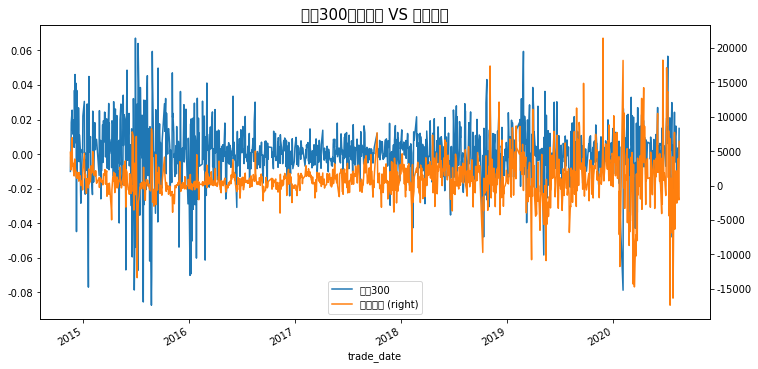

In [52]:
# import seaborn as sns
# plt.figure(figsize=(10, 6))
# sns.regplot(x=list(all_data["北向资金"][-120:]),y=list(all_data["沪深300"][-120:]))
# plt.title('沪深300与北向资金拟合回归线',size=15)
# plt.xlabel('北向资金',size=12)
# plt.ylabel('沪深300收益率',size=12)
# plt.show()

final_data=all_data[['沪深300','北向资金']].dropna()
final_data.plot(secondary_y='北向资金',figsize=(12,6))
plt.title('沪深300日收益率 VS 北向资金',size=15)
plt.show()

In [61]:
cors=final_data.rolling(120).corr()
print(cors)
cors=cors.dropna().iloc[1::2,0]
print(cors)
cors=cors.reset_index()
print(cors)
cors=cors.set_index('trade_date')
print(cors)
cors.describe()

                     沪深300      北向资金
trade_date                          
2014-11-18 沪深300       NaN       NaN
           北向资金        NaN       NaN
2014-11-19 沪深300       NaN       NaN
           北向资金        NaN       NaN
2014-11-20 沪深300       NaN       NaN
...                    ...       ...
2020-08-12 北向资金   0.700535  1.000000
2020-08-13 沪深300  1.000000  0.700734
           北向资金   0.700734  1.000000
2020-08-14 沪深300  1.000000  0.703704
           北向资金   0.703704  1.000000

[2714 rows x 2 columns]
trade_date      
2015-05-21  北向资金    0.276813
2015-05-22  北向资金    0.292587
2015-05-26  北向资金    0.303384
2015-05-27  北向资金    0.307343
2015-05-28  北向资金    0.361411
                      ...   
2020-08-10  北向资金    0.703181
2020-08-11  北向资金    0.699737
2020-08-12  北向资金    0.700535
2020-08-13  北向资金    0.700734
2020-08-14  北向资金    0.703704
Name: 沪深300, Length: 1238, dtype: float64
     trade_date level_1     沪深300
0    2015-05-21    北向资金  0.276813
1    2015-05-22    北向资金  0.292587
2    2015-05-2

,沪深300
count,1238.000000
mean,0.335153
std,0.220124
min,-0.215172
25%,0.219951
50%,0.380906
75%,0.525685
max,0.705992


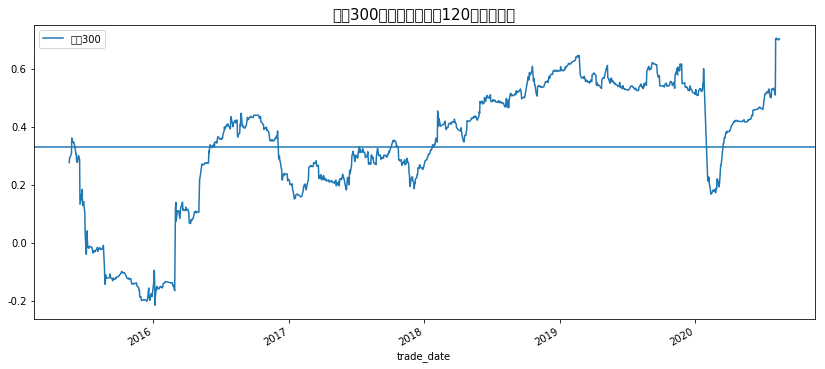

In [63]:
cors.plot(figsize=(14,6),label='移动120日相关系数')
plt.title('沪深300与北向资金移动120日相关系数',size=15)
plt.axhline(0.33)
plt.legend(loc=2)
plt.show()

In [64]:
def North_Strategy(data,window,stdev_n,cost):
    '''输入参数：
    data:包含北向资金和指数价格数据
    window:移动窗口
    stdev_n:几倍标准差
    cost:手续费
    '''
    # 中轨
    df=data.copy().dropna()
    df['mid'] = df['北向资金'].rolling(window).mean()
    stdev = df['北向资金'].rolling(window).std()
    # 上下轨
    df['upper'] = df['mid'] + stdev_n * stdev
    df['lower'] = df['mid'] - stdev_n * stdev
    df['ret']=df.close/df.close.shift(1)-1
    df.dropna(inplace=True)
   
    #设计买卖信号
    #当日北向资金突破上轨线发出买入信号设置为1
    df.loc[df['北向资金']>df.upper, 'signal'] = 1
    #当日北向资金跌破下轨线发出卖出信号设置为0
    df.loc[df['北向资金']<df.lower, 'signal'] = 0
    df['position']=df['signal'].shift(1)
    df['position'].fillna(method='ffill',inplace=True)
    df['position'].fillna(0,inplace=True)
    #根据交易信号和仓位计算策略的每日收益率
    df.loc[df.index[0], 'capital_ret'] = 0
    #今天开盘新买入的position在今天的涨幅(扣除手续费)
    df.loc[df['position'] > df['position'].shift(1), 'capital_ret'] =                          (df.close/ df.open-1) * (1- cost) 
    #卖出同理
    df.loc[df['position'] < df['position'].shift(1), 'capital_ret'] =                    (df.open / df.close.shift(1)-1) * (1-cost) 
    # 当仓位不变时,当天的capital是当天的change * position
    df.loc[df['position'] == df['position'].shift(1), 'capital_ret'] =                         df['ret'] * df['position']
    #计算标的、策略、指数的累计收益率
    df['策略净值']=(df.capital_ret+1.0).cumprod()
    df['指数净值']=(df.ret+1.0).cumprod()
    return df

In [65]:
def performance(df):
    df1 = df.loc[:,['ret','capital_ret']]
    # 计算每一年(月,周)股票,资金曲线的收益
    year_ret = df1.resample('A').apply(lambda x: (x + 1.0).prod() - 1.0)
    month_ret = df1.resample('M').apply(lambda x: (x + 1.0).prod() - 1.0)
    week_ret = df1.resample('W').apply(lambda x: (x + 1.0).prod() - 1.0)
    #去掉缺失值
    year_ret.dropna(inplace=True)
    month_ret.dropna(inplace=True)
    week_ret.dropna(inplace=True)
    # 计算策略的年（月，周）胜率
    year_win_rate = len(year_ret[year_ret['capital_ret'] > 0]) / len(year_ret[year_ret['capital_ret'] != 0])
    month_win_rate = len(month_ret[month_ret['capital_ret'] > 0]) / len(month_ret[month_ret['capital_ret'] != 0])
    week_win_rate = len(week_ret[week_ret['capital_ret'] > 0]) / len(week_ret[week_ret['capital_ret'] != 0])
    #计算总收益率、年化收益率和风险指标
    total_ret=df[['策略净值','指数净值']].iloc[-1]-1
    annual_ret=pow(1+total_ret,250/len(df1))-1
    dd=(df[['策略净值','指数净值']].cummax()-        df[['策略净值','指数净值']])/        df[['策略净值','指数净值']].cummax()
    d=dd.max()
    beta=df[['capital_ret','ret']].cov().iat[0,1]/df['ret'].var()
    alpha=(annual_ret['策略净值']-annual_ret['指数净值']*beta)
    exReturn=df['capital_ret']-0.03/250
    sharper_atio=np.sqrt(len(exReturn))*exReturn.mean()/exReturn.std()
    TA1=round(total_ret['策略净值']*100,2)
    TA2=round(total_ret['指数净值']*100,2)
    AR1=round(annual_ret['策略净值']*100,2)
    AR2=round(annual_ret['指数净值']*100,2)
    MD1=round(d['策略净值']*100,2)
    MD2=round(d['指数净值']*100,2)
    S=round(sharper_atio,2)
    #输出结果
    print (f'策略年胜率为：{round(year_win_rate*100,2)}%' )
    print (f'策略月胜率为：{round(month_win_rate*100,2)}%' )
    print (f'策略周胜率为：{round(week_win_rate*100,2)}%' )
   
    print(f'总收益率：  策略：{TA1}%，沪深300：{TA2}%')
    print(f'年化收益率：策略：{AR1}%, 沪深300：{AR2}%')
    print(f'最大回撤：  策略：{MD1}%, 沪深300：{MD2}%')
    print(f'策略Alpha： {round(alpha,2)}, Beta：{round(beta,2)}，夏普比率：{S}')

In [66]:
def plot_performance(df,name):
    d1=df[['策略净值','指数净值','signal']]
    d1[['策略净值','指数净值']].plot(figsize=(15,7))
    
    for i in d1.index:
        v=d1['指数净值'][i]
        if d1.signal[i]==1:
            plt.scatter(i, v, c='r')
        if d1.signal[i]==0:
            plt.scatter(i, v, c='g')
    
    plt.title(name+'—'+'北向资金择时交易策略回测',size=15)
    plt.xlabel('')
    ax=plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    plt.show()

In [67]:
def main(code='000300.SH',start='20141117',end='20200812',window=252,stdev_n=1.5,cost=0.001):
    hs300=get_index_data(code,start,end)
    north_data=get_north_money(start,end)
    result_df=hs300.join(north_data['north_money'],how='inner')
    result_df.rename(columns={'north_money':'北向资金'},inplace=True)
    result_df=result_df[['close','open','北向资金']].dropna()
    df=North_Strategy(result_df,window,stdev_n,cost)
    name=list (indexs.keys()) [list (indexs.values()).index (code)]
    print(f'回测标的：{name}指数')
    startDate=df.index[0].strftime('%Y%m%d')
    print(f'回测期间：{startDate}—{end}')
    performance(df)
    plot_performance(df,name)

回测标的：沪深300指数
回测期间：20171205—20200812
策略年胜率为：50.0%
策略月胜率为：65.52%
策略周胜率为：61.86%
总收益率：  策略：72.01%，沪深300：15.65%
年化收益率：策略：23.93%, 沪深300：5.92%
最大回撤：  策略：17.29%, 沪深300：32.46%
策略Alpha： 0.21, Beta：0.45，夏普比率：2.1


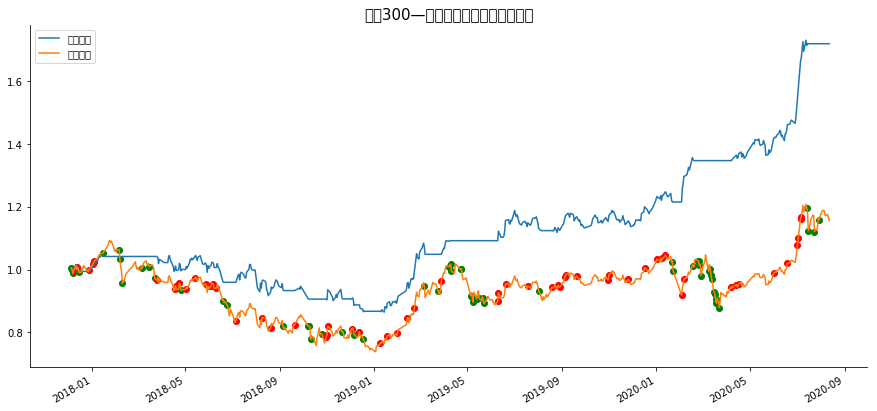

In [69]:
main(code='000300.sh',start='20161117',cost=0.01)